# This notebook must be run with the Vizgen_2 conda environment within the Vizgen.sif singularity container

# since a good portion of the genes in the panel can help us annotate the cerebellum we need to go
# through and clean up the annotation

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ad_viz= sc.read_h5ad('baysor_regions_labeled.h5ad')
ad_genes = sc.read_h5ad('../preprocessing/baysor_segmented_6-5_micron.h5ad')
ad_genes.obs_names_make_unique()
new_adata = ad_viz.copy()

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
regions = ['Cortex', 'Hippocampus', 'Thalamus', 'Hypothalamus', 'Basal_Ganglia', 'MPM', 'Cerebellum']

# Create the 'Brain_Region' column with default value as 'Unlabeled'
new_adata.obs['Brain_Region'] = 'Unlabeled'

# Assign the brain region based on the True values in the respective columns
for region in regions:
    new_adata.obs.loc[new_adata.obs[region] == True, 'Brain_Region'] = region

# Verify the new column
print(new_adata.obs[['Brain_Region']].head())

new_adata.obsm['spatial'] = new_adata.obs[["aligned_x", "aligned_y"]].values

new_adata.write_h5ad('COMPLETE_Baysor.h5ad')

       Brain_Region
CellID             
2.0-9     Unlabeled
3.0-10    Unlabeled
4.0-9    Cerebellum
6.0-9    Cerebellum
8.0-9    Cerebellum


/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-09 08:26:22.257813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 08:26:22.269598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 08:26:22.273011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 08:26:22.284041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFl

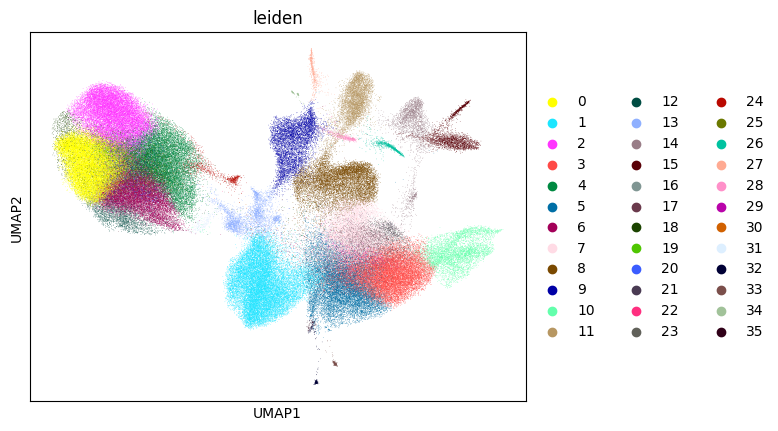

In [4]:
# Now we want to clean up the CB annotation
cerebellum_cells = new_adata[new_adata.obs['Brain_Region'] == 'Cerebellum']

cerebellum_cells = new_adata[new_adata.obs['Brain_Region'] == 'Cerebellum']

sc.pp.neighbors(cerebellum_cells)
sc.tl.leiden(cerebellum_cells, resolution=1.5,random_state=42)
sc.tl.umap(cerebellum_cells)

sc.pl.umap(cerebellum_cells,color=['leiden'])

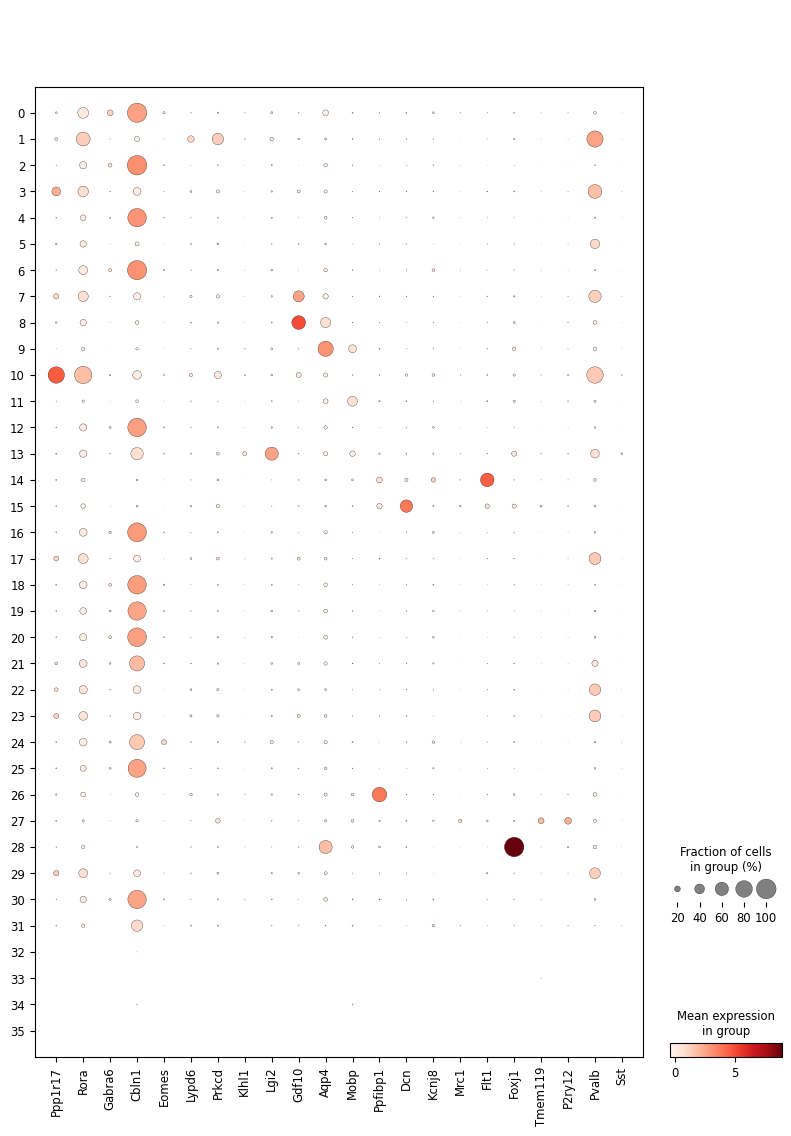

In [5]:
# Use the marker genes from: https://www.nature.com/articles/s41586-021-03220-z
genes = ['Ppp1r17','Rora', 'Gabra6','Cbln1', 'Eomes','Lypd6','Prkcd','Klhl1', 'Lgi2','Gdf10', 'Aqp4','Mobp', 'Ppfibp1','Dcn','Kcnj8', 'Mrc1', 'Flt1', 'Foxj1', 'Tmem119','P2ry12','Pvalb','Sst'] 
sc.pl.dotplot(cerebellum_cells, var_names=genes, groupby='leiden')

In [6]:
# map the leiden clusters to the CB annotations based on marker gene expression
cluster_annotations = {
    '0': 'Granule cells',
    '1': 'Molecular layer interneurons',
    '2': 'Granule cells',
    '3': 'Pvalb+ interneurons',
    '4': 'Granule cells',
    '5': 'Pvalb+ interneurons',
    '6': 'Granule cells',
    '7': 'Bergmann Glia',
    '8': 'Bergmann Glia',
    '9': 'Astrocytes',
    '10': 'Purkinje cells',
    '11': 'Oligodendrocytes',
    '12': 'Granule cells',
    '13': 'Golgi cells',
    '14': 'Endothelial cells',
    '15': 'Fibroblasts',
    '16': 'Granule cells',
    '17': 'Pvalb+ Interneurons',
    '18': 'Granule cells',
    '19': 'Granule cells',
    '20': 'Granule cells',
    '21': 'Granule cells',
    '22': 'Pvalb+ interneurons',
    '23': 'Pvalb+ interneurons',
    '24': 'Granule cells',
    '25': 'Granule cells',
    '26': 'Oligodendrocyte precursor cells',
    '27': 'Microglia',
    '28': 'Ependymal cells',
    '29': 'Pvalb+ interneurons',
    '30': 'Granule cells',
    '31': 'Granule cells',
    '32': 'Unknown',
    '33': 'Unknown',
    '34': 'Unknown',
    '35': 'Unknown',
}

cerebellum_cells.obs['updated_celltype'] = cerebellum_cells.obs['leiden'].map(cluster_annotations)

# Reapply this clean up to the main data object

# Ensure indices are of the same type
new_adata.obs.index = new_adata.obs.index.astype(str)
cerebellum_cells.obs.index = cerebellum_cells.obs.index.astype(str)

# Step 4: Update the main AnnData object
# Convert the existing cell type column to strings
new_adata.obs['updated_celltype'] = new_adata.obs['celltype'].astype(str)

# Update the cell types for cerebellum cells based on the new annotations
new_adata.obs.loc[cerebellum_cells.obs.index, 'updated_celltype'] = cerebellum_cells.obs['updated_celltype'].astype(str)

# Since I annotated the cerebellum fully I want to remove any Cerebellum neurons that escaped my annotation

sensical_adata = new_adata[~(new_adata.obs.updated_celltype == 'Cerebellum neurons')]

# Final Cleaned up Annotation from scVI and scANVI
sensical_adata.write_h5ad('FINAL_ANNOTATION.h5ad')

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
